# 4 Degree of Freedom Robot Arm

In [1]:
import time
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from IPython.display import display, Math

from tools import *

## Variables and settings

In [2]:
# Constants
l0 = symbols('l_0')
l2 = symbols('l_2')
l3 = symbols('l_3')
l4 = symbols('l_4')
le = symbols('l_e')
l0_val = 5
l2_val = 20
l3_val = 15
l4_val = 5
le_val = 3

# Variables
theta2 = symbols(r"\theta_2")
theta3 = symbols(r"\theta_3")
theta4 = symbols(r"\theta_4")
d1 = symbols('d_1')

alias = {}

# display cos(theta) as c\theta, sin(theta) as s\theta
alias.update({sin(theta2): symbols(r"s\theta_2"),
              cos(theta2): symbols(r"c\theta_2"),
              sin(theta3): symbols(r"s\theta_3"),
              cos(theta3): symbols(r"c\theta_3"),
              sin(theta4): symbols(r"s\theta_4"),
              cos(theta4): symbols(r"c\theta_4")})

## Transformation Metrics (see forward_kinematics.py)

In [3]:
R01, T01 = get_trans_mat(0, 0, l0+d1, 0)
R12, T12 = get_trans_mat(0, 0, 0, theta2)
R23, T23 = get_trans_mat(l2, 90, 0, theta3+pi/2)
R34, T34 = get_trans_mat(0, 90, l3, theta4)
R4e, T4e = get_trans_mat(-le, 0, l4, 0)

T04 = T01 * T12 * T23 * T34
T0e = T04 * T4e

## Inverse Kinematics to find $\theta$ values from the position metrices

In [4]:
def get_random_trans_mat():
    """
    Obtain random position metrices by applying forward kinematics using
    randomly assigned theta2, theta3, theta4 & d1 values.
    Random assignment is for proving concepts and is practically useless.
    """
    theta2_val = (np.random.rand()*360-180)/180*np.pi
    theta3_val = (np.random.rand()*300-150)/180*np.pi
    theta4_val = (np.random.rand()*360-180)/180*np.pi
    d1_val = np.random.rand() * 40

    values = {l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val, 
              theta2: theta2_val, theta3: theta3_val, theta4: theta4_val, 
              d1: d1_val}
    T0e_target = T0e.subs(values)
    # convert infinitely small non-zero float to zero
    T0e_target = np.array(T0e_target, dtype=np.float32)
    T0e_target[np.abs(T0e_target) < 1e-7] = 0
    
    return T0e_target

In [5]:
def solve_inverse_kinematics(vals_target, show_ans=False):
    # ========================= d1 ==============================
    d1_inv =le*r31 - l4*r33 + Z - l0 - l3*r33
    d1_ans = float(d1_inv.subs(vals_target))
    if show_ans:
        eqnprint(d1, alias, None, d1_ans)

    # ========================= theta2 ==========================
    theta2_inv = atan2((le*r21 - r23*(l3+l4) + Y)/l2, (le*r11 - r13*(l3+l4) + X)/l2)
    theta2_ans = float(theta2_inv.subs(vals_target))
    if show_ans:
        eqnprint(theta2, alias, None, theta2_ans)

    # ========================= theta3 ==========================
    if sin(theta2_ans) != 0:
        theta3_inv = atan2(r33, r23/sin(theta2_ans))
    else:
        theta3_inv = atan2(r33, r13/cos(theta2_ans))

    theta3_ans = float(theta3_inv.subs(vals_target))
    # theta3 range from -180 to 180 deg
    if theta3_ans > np.pi:
        theta3_ans -= 2*np.pi 
    if show_ans:
        eqnprint(theta3, alias, None, theta3_ans)

    # ========================= theta4 ==========================
    if theta3_ans == np.pi/2:
        theta4_inv = atan2(r12, -r11) - theta2_ans
    elif theta3_ans == -np.pi/2:
        theta4_inv = atan2(-r12, r11) + theta2_ans
    else:
        theta4_inv = atan2(-r32/cos(theta3_ans), r31/cos(theta3_ans))

    theta4_ans = float(theta4_inv.subs(vals_target))
    # theta4 range from -180 to 180 deg
    if theta4_ans > np.pi:
        theta4_ans -= 2*np.pi 
    if show_ans:
        eqnprint(theta4, alias, None, theta4_ans)
    
    return d1_ans, theta2_ans, theta3_ans, theta4_ans


In [71]:
r11 = symbols('r_{11}')
r12 = symbols('r_{12}')
r13 = symbols('r_{13}')
r21 = symbols('r_{21}')
r22 = symbols('r_{22}')
r23 = symbols('r_{23}')
r31 = symbols('r_{31}')
r32 = symbols('r_{32}')
r33 = symbols('r_{33}')
X = symbols('X')
Y = symbols('Y')
Z = symbols('Z')
empty_vals = {r11: None, r12: None, r13: None, 
              r21: None, r22: None, r23: None, 
              r31: None, r32: None, r33: None, 
              X: None, Y: None, Z: None}

In [72]:
num_via_points = 10

# + 2 because start and end points:
d1_points = np.ndarray(num_via_points + 2)
theta2_points = np.ndarray(num_via_points + 2)
theta3_points = np.ndarray(num_via_points + 2)
theta4_points = np.ndarray(num_via_points + 2)

# XYZ values for target positions:
P_coordinates = np.ndarray([num_via_points + 2, 3])

for i in range(num_via_points + 2):
    P = get_random_trans_mat()
#     print(P[:3, -1])
    P_coordinates[i, :] = P[:3, -1]
    # get rii, X, Y, Z
    vals_target = update_target_vals(P, empty_vals)
    vals_target.update({l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val})
    if i == 0:
        print('======> Start Position:')
        symprint('P', 0, 'start')
        matprint(Matrix(P))
        show_ans = True
    elif i == num_via_points + 1:
        print('======> End Position:')
        symprint('P', 0, 'start')
        matprint(Matrix(P))
        show_ans = True
    else:
        show_ans = False
        
    # solve theta values
    d1_points[i], theta2_points[i], theta3_points[i], theta4_points[i] = solve_inverse_kinematics(vals_target, show_ans=show_ans)

======> Start Position:


^0P_start

Matrix([
[-0.809362, -0.501842, 0.305103, 20.6394],
[  0.58716, -0.703135, 0.401054, 22.1771],
[0.0132634,  0.503742, 0.863752, 24.6897],
[        0,         0,        0,     1.0]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

======> End Position:


^0P_start

Matrix([
[ 0.420581, -0.461156,  -0.781311, 3.11203],
[-0.738483, -0.674272, 0.00045114, 2.21292],
[-0.527024,  0.576795,  -0.624142, 4.85987],
[        0,         0,          0,     1.0]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now we have arrays for each theta, each array has a length of 12, corresponding to 12 points.

Then we need arrays with length 11, corresponding to 11 segments.

In [126]:
def calc_kinematics_parameters(via_points, tf):
    a_mins = np.ndarray(num_via_points + 2)  # minimum required accelerations
    a_vals = np.ndarray(num_via_points + 2)  # actual acclerations
    V_vals = np.ndarray(num_via_points + 1)  # velocity for linear regions
    t_blends = np.ndarray(num_via_points + 2)  # time for blend regions
    t_linears = np.ndarray(num_via_points + 1)  # time for linear regions

#     a_mins[:-1] = 2 * (via_points[1:] - via_points[:-1]) / (tf/2)**2
#     a_mins[-1] = a_mins[-2]  # make the last acceleration magnitude = second last 

    a_mins[0] = np.abs(8*(via_points[1]-via_points[0]) / (3*tf[0]**2))
    a_mins[-1] = np.abs(8*(via_points[-1]-via_points[-2]) / (3*tf[-1]**2))
    # for the middle segments:
    left = ((via_points[2:]-via_points[1:-1])/tf[1:] - (via_points[1:-1]-via_points[:-2])/tf[:-1]) / tf[:-1]
    right = ((via_points[2:]-via_points[1:-1])/tf[1:] - (via_points[1:-1]-via_points[:-2])/tf[:-1]) / tf[1:]
    a_mins[1:-1] = np.maximum(np.abs(left), np.abs(right))
    a_mins = 1.5 * a_mins

    # Step 1: Find the start and end acceleration:
    a_vals[0] = np.sign(via_points[1] - via_points[0]) * a_mins[0]
    a_vals[-1] = np.sign(via_points[-2] - via_points[-1]) * a_mins[-1]

    # Step 2: Find the start and end blend times (using a_vals[0] and a_vals[-1]):
    t_blends[0] = tf[0] - np.sqrt(tf[0]**2 - 2*(via_points[1]-via_points[0])/a_vals[0])
    t_blends[-1] = tf[-1] - np.sqrt(tf[-1]**2 + 2*(via_points[-1]-via_points[-2])/a_vals[-1])

    # Step3: Find the start and end velocity (using t_blends[0] and t_blends[-1]):
    V_vals[0] = (via_points[1]-via_points[0]) / (tf[0]-0.5*t_blends[0])
    V_vals[-1] = (via_points[-1]-via_points[-2]) / (tf[-1]-0.5*t_blends[-1])

    # Step 4: Find middle via points velocity at linear regions:
    V_vals[1:-1] = (via_points[2:-1] - via_points[1:-2]) / tf[1:-1]

    # Step 5: Find middle via points blend acceleration (using V_vals[:]):
    a_vals[1:-1] = np.sign(V_vals[1:] - V_vals[:-1]) * a_mins[1:-1]

    # Step 6: Find middle via points blend times (using V_vals[:] and a_vals[1:-1]):
    t_blends[1:-1] = (V_vals[1:] - V_vals[:-1]) / a_vals[1:-1]

    # Step 6: Find all times for linear regions (using t_blends[:]):
    t_linears[0] = tf[0] - t_blends[0] - 0.5*t_blends[1]
    t_linears[-1] = tf[-1] - t_blends[-1] - 0.5*t_blends[-2]
    t_linears[1:-1] = tf[1:-1] - 0.5*t_blends[2:-1] - 0.5*t_blends[1:-2]

    print('via_points:', via_points)
    print('a_vals:', a_vals)
    print('V_vals:', V_vals)
    print('t_blends:', t_blends)
    print('t_linears:', t_linears)
    
    return a_vals, V_vals, t_blends, t_linears

In [127]:
# calculate distance between two points position
dist = np.sqrt(np.sum((P_coordinates[1:] - P_coordinates[:-1])**2, axis=1))
# time between two points depending on the distance
tf = dist/20
print('tf:', tf)

display(d1)
a_vals_d1, V_vals_d1, b_blends_d1, t_linears_d1 = calc_kinematics_parameters(d1_points, tf)

display(theta2)
a_vals_theta2, V_vals_theta2, b_blends_theta2, t_linears_theta2 = calc_kinematics_parameters(theta2_points, tf)

display(theta3)
a_vals_theta3, V_vals_theta3, b_blends_theta3, t_linears_theta3 = calc_kinematics_parameters(theta3_points, tf)

display(theta4)
a_vals_theta4, V_vals_theta4, b_blends_theta4, t_linears_theta4 = calc_kinematics_parameters(theta4_points, tf)

tf: [2.49274937 2.21749814 3.83017457 2.1847995  2.35921422 0.49408688
 3.12493674 2.01553064 2.91241853 2.2702057  0.76881142]


d_1

via_points: [ 2.45439529 11.15728951 21.84122086 32.05021667  8.18365479 25.60723495
 15.72808266  6.62366533 38.63332748  6.33697891 22.45641136 10.76163483]
a_vals: [  5.60230133   0.89744932  -1.45609959  -9.32991335  12.57042989
 -83.12333461  51.85715997  13.98761568 -20.07215186  12.01847925
 -43.53199578  79.14295636]
V_vals: [  4.09029279   4.81801142   2.66541267 -10.92391402   7.38533195
 -19.99476747  -2.91347252  15.88150612 -11.08918525   7.10042815
 -17.82138329]
t_blends: [0.73010939 0.81087434 1.47833209 1.456533   1.456533   0.32939125
 0.32939125 1.34368709 1.34368709 1.51347047 0.57249412 0.22517965]
t_linears: [1.35720282 1.07289492 2.36274203 0.7282665  1.46625209 0.16469563
 2.28839756 0.67184355 1.48383975 1.22722341 0.25738471]


\theta_2

via_points: [ 9.20448184e-01 -2.09263841e+00 -4.85104263e-01  2.69974610e+00
 -1.49877453e+00  2.45919100e+00  2.23891393e+00 -2.25440994e+00
 -1.26082420e+00  1.35598159e+00 -2.34842387e+00 -5.77420113e-04]
a_vals: [ -1.93960981   1.30800904   0.07209765  -1.8902502    2.47118239
  -6.44670796  -3.01181692   1.43698455   0.30180716  -1.67181858
   9.14193114 -15.88876099]
V_vals: [-1.41612733  0.72493145  0.83151572 -1.92169608  1.67766263 -0.44582659
 -1.43789275  0.49296484  0.89849923 -1.63174881  3.57782565]
t_blends: [0.73010939 1.63688379 1.47833209 1.456533   1.456533   0.32939125
 0.32939125 1.34368709 1.34368709 1.51347047 0.56985492 0.22517965]
t_linears: [0.94419809 0.6598902  2.36274203 0.7282665  1.46625209 0.16469563
 2.28839756 0.67184355 1.48383975 1.228543   0.25870431]


\theta_3

via_points: [ 1.04266915 -1.97587741 -0.51314202  1.13083832  1.94155231 -0.80454792
 -0.38044918 -0.07266384 -1.18864785  0.80667861 -1.88811097 -2.46755525]
a_vals: [-1.94312456  1.26532045 -0.15586151 -0.03992215 -1.05391333  6.13962223
 -2.30684696 -0.48537023  0.92194247 -1.236981    0.84546607  3.92131758]
V_vals: [-1.41869348  0.6596332   0.42921812  0.3710702  -1.16398935  0.85834852
  0.0984933  -0.55369241  0.6851098  -1.18702441 -0.88300092]
t_blends: [0.73010939 1.64252991 1.47833209 1.456533   1.456533   0.32939125
 0.32939125 1.34368709 1.34368709 1.51347047 0.35959277 0.22517965]
t_linears: [0.94137503 0.65706714 2.36274203 0.7282665  1.46625209 0.16469563
 2.28839756 0.67184355 1.48383975 1.33367408 0.36383538]


\theta_4

via_points: [-1.54447271  1.61581543  2.75413863  1.3668786   2.35099178 -2.52621635
 -2.20830616 -2.5279115   1.98895404  2.63637923  0.12837219  0.83045724]
a_vals: [ 2.03436765 -0.51034234 -0.59224114  0.55791991 -1.72858309  8.22951926
 -2.26388983  1.74393744 -1.50238276 -0.87682381  3.93716294 -4.75127391]
V_vals: [ 1.48531092  0.51333671 -0.36219238  0.45043638 -2.06730194  0.64342973
 -0.10227578  2.24103045  0.22229813 -1.10474881  1.0698902 ]
t_blends: [0.73010939 1.90455334 1.47833209 1.456533   1.456533   0.32939125
 0.32939125 1.34368709 1.34368709 1.51347047 0.55233655 0.22517965]
t_linears: [0.81036332 0.52605542 2.36274203 0.7282665  1.46625209 0.16469563
 2.28839756 0.67184355 1.48383975 1.23730219 0.26746349]


In [154]:
def plot_trajectory(via_points, tf, a_vals, V_vals, t_blends, t_linears, ylabel):
    # for the whole trajectory
    time_history = []
    disp_history = []
    velo_history = []
    acc_history = []
    disp_ideal_history = []
    t_start = 0

    # initialise starting values
    disp_last = via_points[0]
    velo_last = 0
    
    fig, axes = plt.subplots(1, 3)
    # Need plots for each segment:
    for i in range(num_via_points + 1):
        t_local = np.linspace(0, tf[i], 1000)
        tb_left = t_blends[i] if i == 0 else t_blends[i]/2
        tb_right = t_blends[i+1] if i == num_via_points else t_blends[i+1]/2
        disp, velo, acc, disp_ideal = calc_parabolic_traj_via_points(t_local, disp_last, velo_last, 
                                                         V_vals[i], a_vals[i],
                                                         a_vals[i+1], tb_left, tb_right)
        # use last points as the initial points for the next segment
        disp_last = disp[-1]
        velo_last = velo[-1]

        time_history.extend((t_local + t_start).tolist())

        disp_history.extend(disp.tolist())
        velo_history.extend(velo.tolist())
        acc_history.extend(acc.tolist())
        disp_ideal_history.extend(disp_ideal.tolist())

        axes[0].plot(t_start, via_points[i], 'rx')
#         plt.axvline(t_start, color='red', linestyle='--')
        t_start += tf[i]

    axes[0].plot(t_start, via_points[-1], 'rx')
#     plt.axvline(t_start, color='red', linestyle='--')
    axes[0].plot(time_history, disp_ideal_history, 'b--')
    axes[0].plot(time_history, disp_history)
    
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel(ylabel)
    axes[0].set_title(ylabel + ' Displacement')

    axes[1].plot(time_history, velo_history)
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel(ylabel)
    axes[1].set_title(ylabel + ' Velocity')

    axes[2].plot(time_history, acc_history)
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel(ylabel)
    axes[2].set_title(ylabel + ' Acceleration')
    
    fig.set_figheight(5)
    fig.set_figwidth(15)
    plt.show()


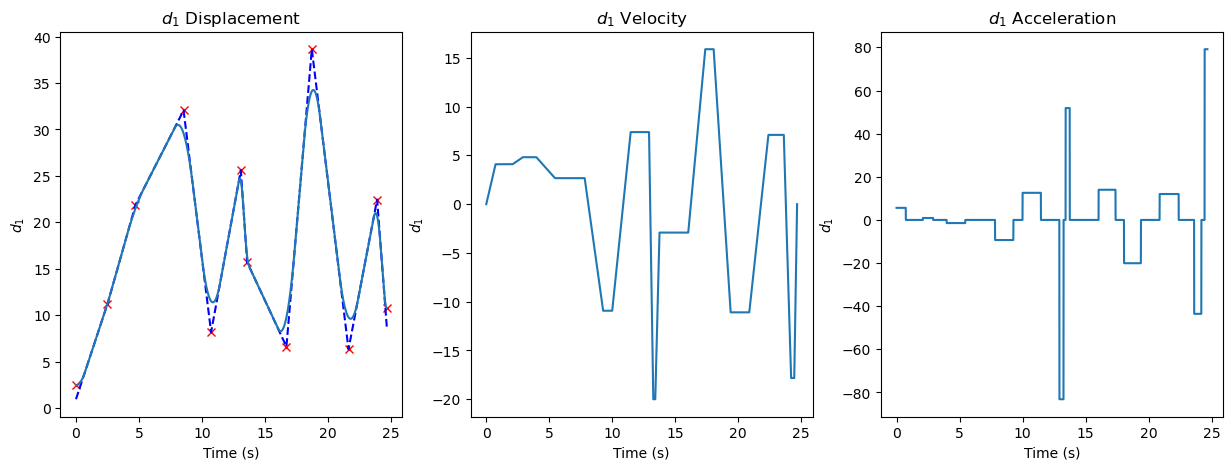

In [155]:
plot_trajectory(d1_points, tf, a_vals_d1, V_vals_d1, b_blends_d1, t_linears_d1, '$d_1$')

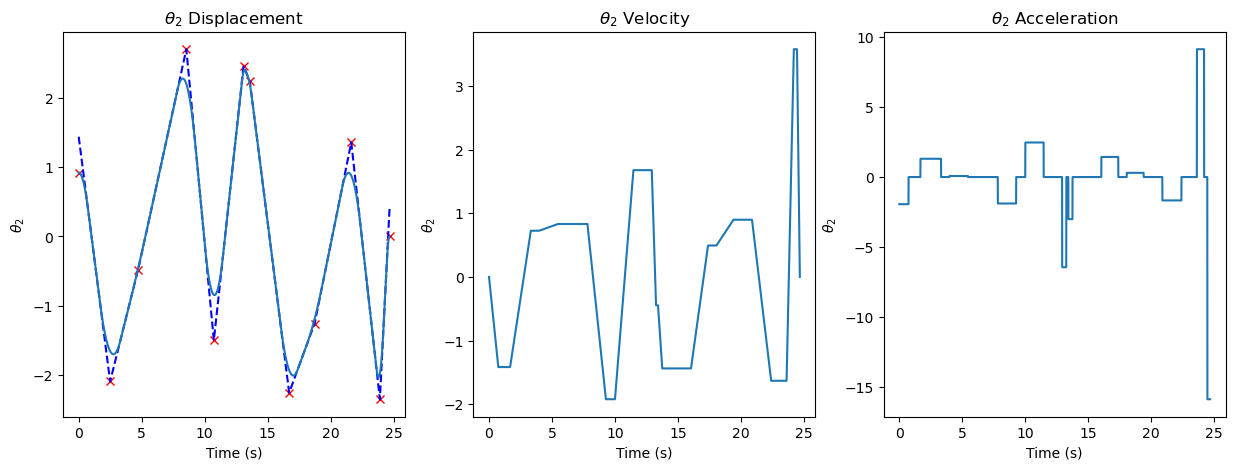

In [156]:
plot_trajectory(theta2_points, tf, a_vals_theta2, V_vals_theta2, b_blends_theta2, t_linears_theta2, '$\\theta_2$')

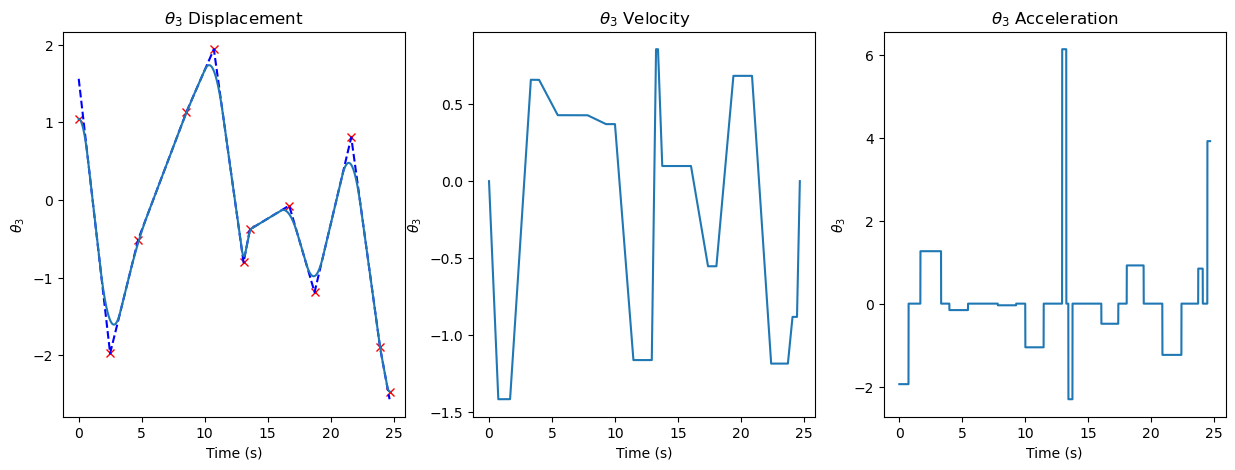

In [157]:
plot_trajectory(theta3_points, tf, a_vals_theta3, V_vals_theta3, b_blends_theta3, t_linears_theta3, '$\\theta_3$')

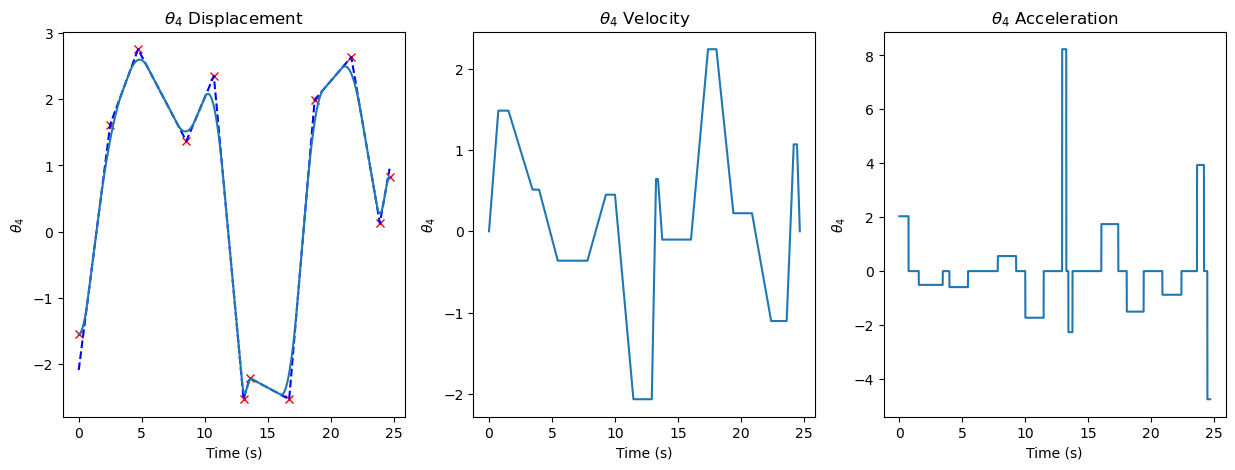

In [158]:
plot_trajectory(theta4_points, tf, a_vals_theta4, V_vals_theta4, b_blends_theta4, t_linears_theta4, '$\\theta_4$')